In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import random

import os
from pathlib import Path

# Directory to save checkpoints
ckpt_dir = Path("checkpoints")
ckpt_dir.mkdir(exist_ok=True)

#Defining Transition Probabilities of HMM, and the Data Generating Function

In [ ]:
# These are same as paper for replication
T0 = np.array([[0.765, 0.00375, 0.00375],
               [0.0425, 0.0675,  0.00375],
               [0.0425, 0.00375, 0.0675]])
T1 = np.array([[0.0675, 0.0425,  0.00375],
               [0.00375,0.765,   0.00375],
               [0.00375,0.0425,  0.0675]])
T2 = np.array([[0.0675, 0.00375, 0.0425],
               [0.00375,0.0675,  0.0425],
               [0.00375,0.00375,0.765]])

# The overall transition matrix for the HMM
Ts = [T0, T1, T2]

In [ ]:
# We find stationary distribution
P = T0 + T1 + T2
w, v = np.linalg.eig(P.T)

# Tv = v for stationary distribution
pi = v[:, np.isclose(w,1.0)].real.squeeze()
pi /= pi.sum()

pi

array([0.33333333, 0.33333333, 0.33333333])

In [ ]:
def sample_batch(batch_size, seq_len):
    """Returns tokens [B, seq_len] and true beliefs [B, seq_len, 3]."""
    tokens  = torch.zeros(batch_size, seq_len, dtype=torch.long)
    beliefs = torch.zeros(batch_size, seq_len, 3)
    b = np.tile(pi[None,:], (batch_size,1))
    for t in range(seq_len):
        # emission probs
        em_ps = np.stack([b.dot(T.sum(axis=1)) for T in Ts], axis=-1)
        em_ps /= em_ps.sum(axis=1, keepdims=True)
        em = np.array([np.random.choice(3, p=em_ps[i]) for i in range(batch_size)])
        tokens[:,t] = torch.from_numpy(em)
        beliefs[:,t] = torch.from_numpy(b.astype(np.float32))
        # belief update
        for i in range(batch_size):
            b[i] = b[i].dot(Ts[em[i]])
            b[i] /= b[i].sum()
    return tokens, beliefs

#Hyperparameter choices and model definition

In [ ]:
seq_len    = 8    # context window... paper does not explicitly say it but I assume 8 because its small enough that I can
                  # capture activations for all possible input sequences
batch_size = 64
epochs     = 100_000
save_every = 10_000
lr         = 0.001

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, seq_len, vocab_size=3, emb_dim=64,
                 hidden_size=128, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.lstm  = nn.LSTM(input_size=emb_dim,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True)
        self.unembed = nn.Linear(hidden_size, vocab_size)
        self.seq_len = seq_len

    def forward(self, x, return_hidden=False):
        # x: [B, T]
        e = self.embed(x)                   # [B, T, emb_dim]
        out, (h_n, c_n) = self.lstm(e)      # out: [B, T, hidden_size]
        logits = self.unembed(out)          # [B, T, vocab_size]
        if return_hidden:
            return logits, out              # out = hidden states per timestep
        return logits, None

model = LSTMModel(seq_len).to(device)

#Training loop (and saving checkpoints)

In [ ]:
opt     = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

for step in range(1, epochs + 1):
    model.train()
    tokens, _ = sample_batch(batch_size, seq_len + 1)
    inp, tgt = tokens[:, :-1].to(device), tokens[:, 1:].to(device)

    logits, _ = model(inp)
    loss = loss_fn(logits.reshape(-1, 3), tgt.reshape(-1))

    opt.zero_grad()
    loss.backward()
    opt.step()

    if step % 1000 == 0:
        print(f"Step {step}, loss: {loss.item():.4f}")

    if step % save_every == 0:
        ckpt_path = ckpt_dir / f"model_step_{step:06d}.pt"
        torch.save(model.state_dict(), ckpt_path)
        print(f"Checkpoint saved to {ckpt_path}")

Step 1000, loss: 1.0783


KeyboardInterrupt: 

#Evaluating

In [ ]:
# Generate all sequences for evals
all_seqs = torch.tensor(
    np.array(list(map(list, np.ndindex(*(3,)*seq_len)))),
    dtype=torch.long
).to(device)


all_seqs.shape

torch.Size([6561, 8])

##Run for each saved checkpoint on all seqs

In [ ]:
checkpoint_dir = 'checkpoints'
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])

for checkpoint_file in checkpoint_files:
    # Load the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        _, hidden_states = model(all_seqs, return_hidden=True)
        acts = hidden_states.cpu().numpy().reshape(-1, hidden_states.size(-1))

    # b) Ground-truth beliefs
    ground_beliefs = []
    for seq in all_seqs.cpu().numpy():
        b = pi.copy()
        for x in seq:
            ground_beliefs.append(b.copy())
            b = b.dot(Ts[x])  # Update the belief with each emission
            b /= b.sum()  # Normalize
    ground_beliefs = np.stack(ground_beliefs, axis=0)  # [N×T, 3]

    # --- Linear Regression ---
    reg = LinearRegression(fit_intercept=True)
    reg.fit(acts, ground_beliefs)
    proj = reg.predict(acts)[:, :2]  # First two dimensions for visualization

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')
    plt.axis('off')
    plt.title(f'LSTM Hidden‑State Fractal Belief Geometry\n{checkpoint_file}')

    # Save the plot
    plot_filename = f'fractal_plot_{checkpoint_file}.png'
    plt.savefig(plot_filename)
    plt.close()

    # Optionally, print progress
    print(f'Processed checkpoint: {checkpoint_file}')

<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_010000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_020000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_030000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_040000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_050000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_060000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_070000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_080000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_090000.pt


<ipython-input-29-8ec350a87c6f>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=ground_beliefs, s=1, cmap='viridis')


Processed checkpoint: model_step_100000.pt


Showing: fractal_plot_model_step_010000.pt.png


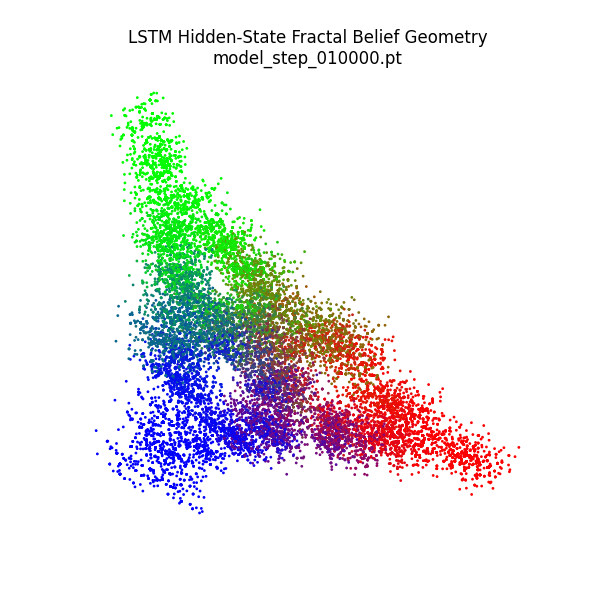

Showing: fractal_plot_model_step_020000.pt.png


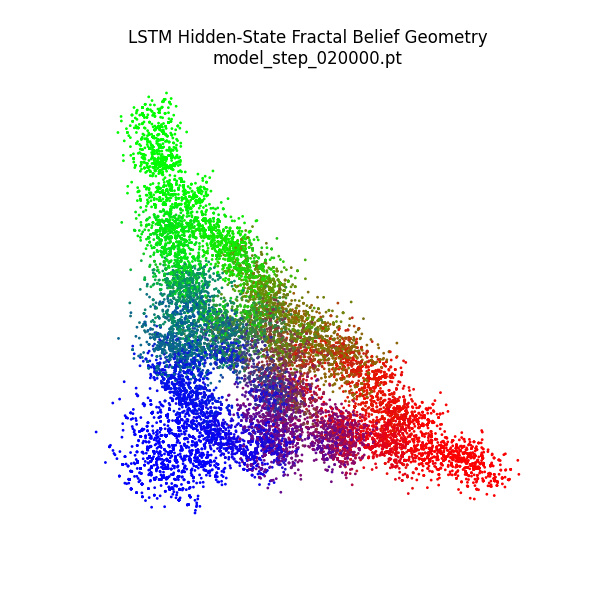

Showing: fractal_plot_model_step_030000.pt.png


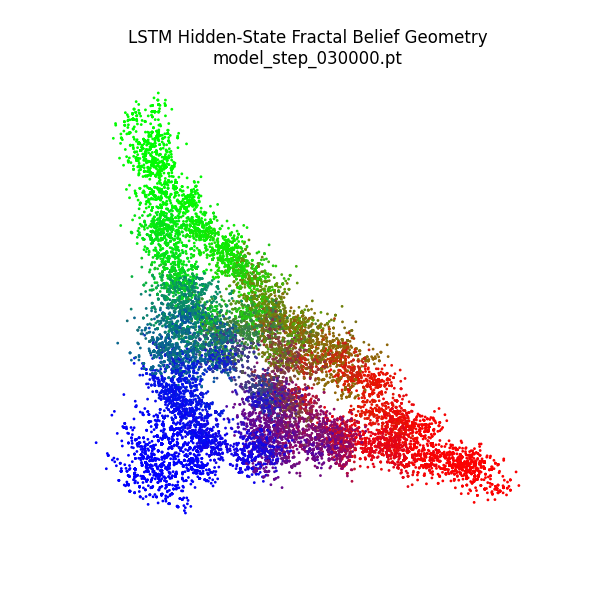

Showing: fractal_plot_model_step_040000.pt.png


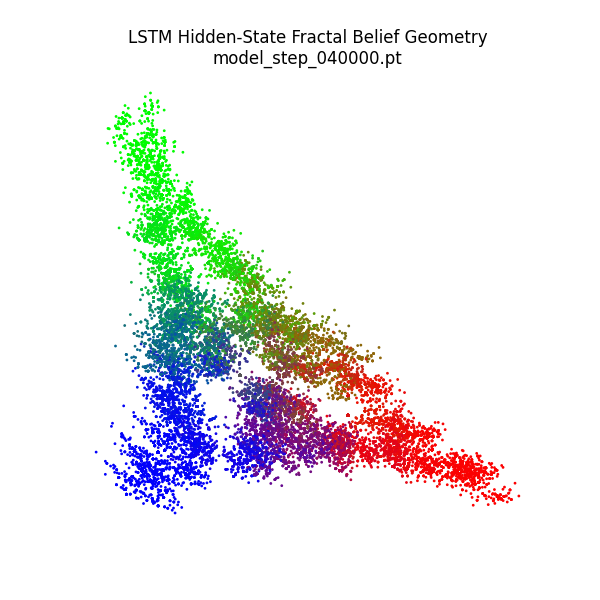

Showing: fractal_plot_model_step_050000.pt.png


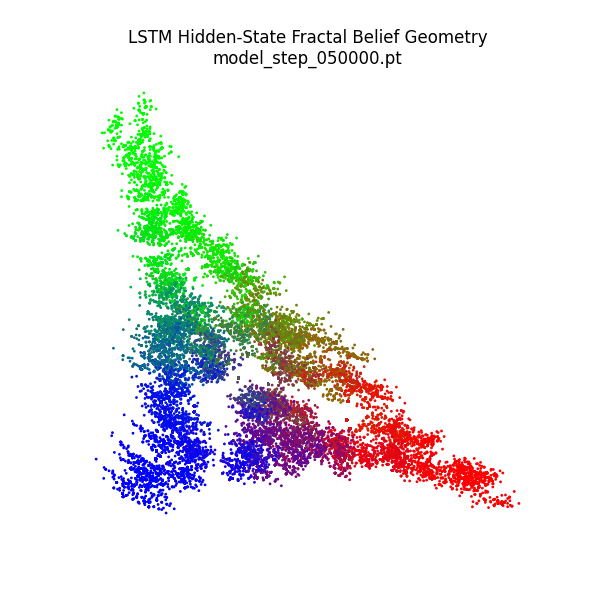

Showing: fractal_plot_model_step_060000.pt.png


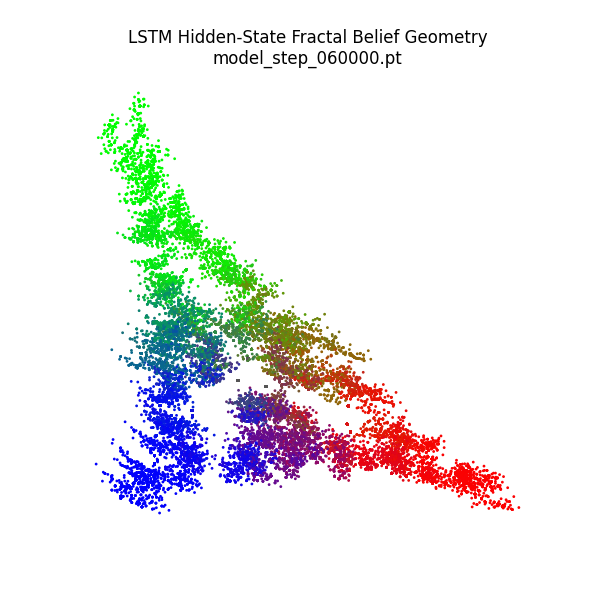

Showing: fractal_plot_model_step_070000.pt.png


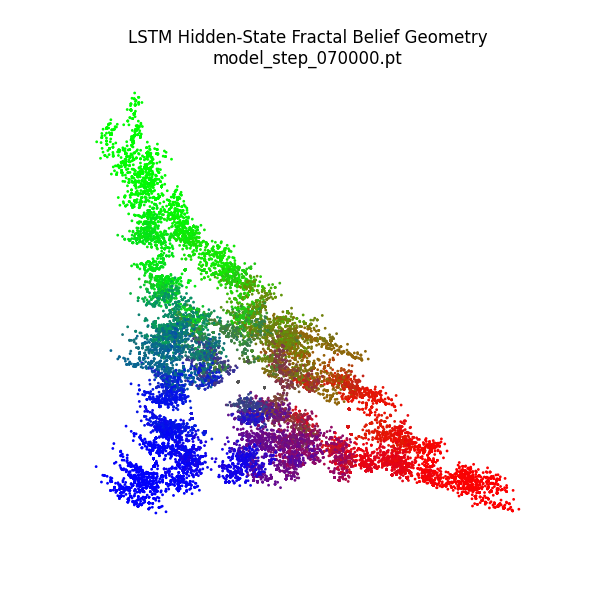

Showing: fractal_plot_model_step_080000.pt.png


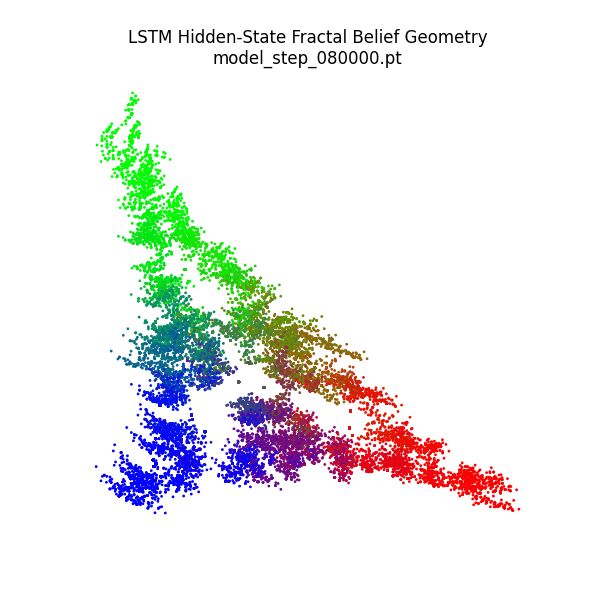

Showing: fractal_plot_model_step_090000.pt.png


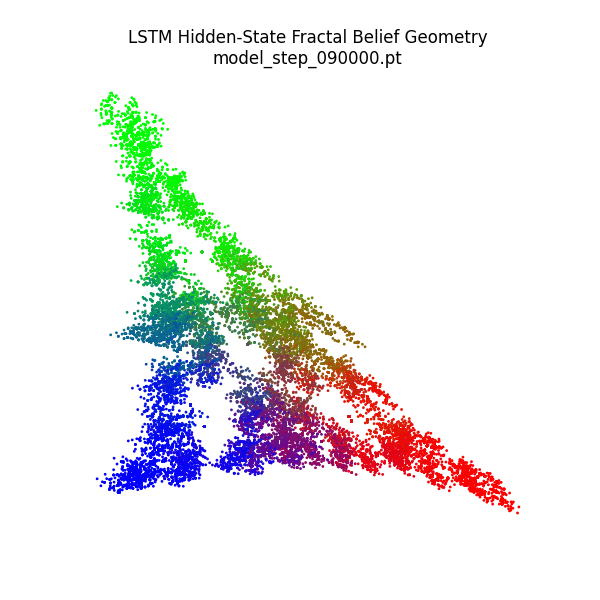

Showing: fractal_plot_model_step_100000.pt.png


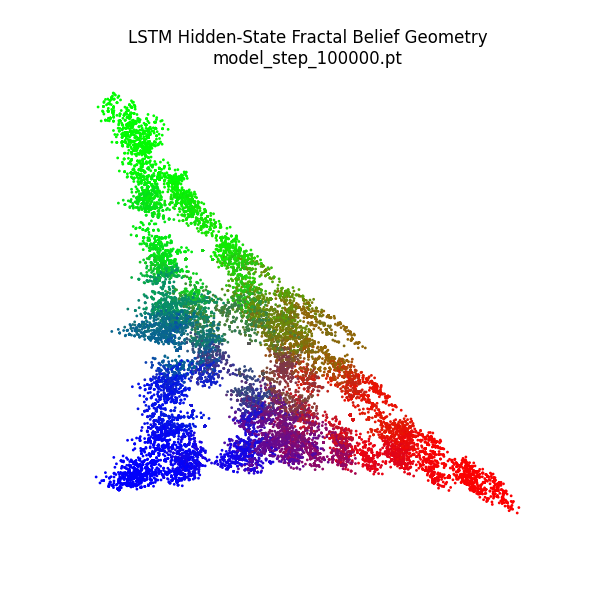

In [ ]:
from IPython.display import Image, display

image_dir = "."
image_files = sorted([
    f for f in os.listdir(image_dir)
    if f.startswith("fractal_plot_model_step_") and f.endswith(".png")
])

for img_file in image_files:
    print(f"Showing: {img_file}")
    display(Image(filename=os.path.join(image_dir, img_file)))

##True belief state geometry

<ipython-input-40-082f360b5edb>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(proj[:, 0], proj[:, 1], c=all_beliefs, cmap='viridis', s=1)


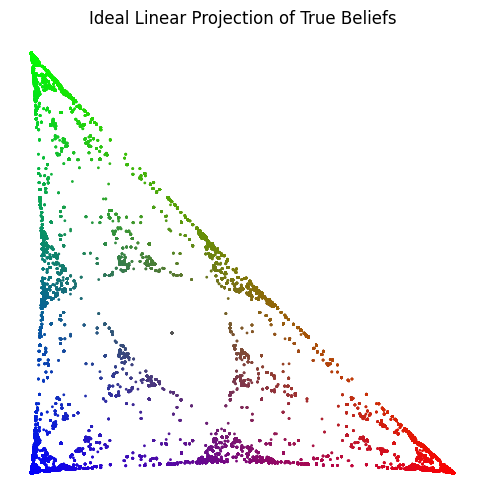

In [ ]:
all_seqs, all_beliefs = sample_batch(batch_size=100_000, seq_len=seq_len)
all_beliefs = all_beliefs.view(-1, 3).numpy()

# Learn a linear projection from beliefs to 2D using regression
reg = LinearRegression()
reg.fit(all_beliefs, all_beliefs)  # identity regression
proj = reg.predict(all_beliefs)[:, :2]  # take first two projected dims

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=all_beliefs, cmap='viridis', s=1)
plt.axis('off')
plt.title('Ideal Linear Projection of True Beliefs')
plt.show()